# SG-FIGS: Synergy-Guided Oblique FIGS — Benchmark Demo

This notebook demonstrates the **SG-FIGS** (Synergy-Guided Oblique FIGS) algorithm, which uses Partial Information Decomposition (PID) synergy to guide oblique split selection in the FIGS (Fast Interpretable Greedy-Tree Sums) framework.

**What this demo does:**
1. Loads pre-computed benchmark results comparing **FIGS** (axis-aligned), **RO-FIGS** (random oblique), and **SG-FIGS** (synergy-guided oblique)
2. Runs a **live small-scale experiment** on the banknote authentication dataset using all three methods
3. Visualizes accuracy, model complexity, and split interpretability across methods

In [ ]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Packages not pre-installed on Colab
_pip('imodels==2.0.4')
_pip('boltons==25.0.0')
_pip('PLTable==1.1.0')
_pip('lattices==0.3.5')
_pip('debtcollector==3.0.0')
_pip('--no-deps', 'dit==1.5')

# Core packages (pre-installed on Colab, only needed locally)
if 'google.colab' not in sys.modules:
    _pip('scipy==1.16.3', 'scikit-learn==1.6.1', 'networkx==3.6.1', 'matplotlib==3.10.0')

## Imports

In [2]:
import json
import random
import time
import warnings
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.linear_model import Ridge
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Loading

Load the pre-computed benchmark results from GitHub (with local fallback).

In [ ]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/test-colab-install/master/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets:")
for ds in data['datasets']:
    print(f"  - {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 2 datasets:
  - banknote: 80 examples
  - pima_diabetes: 40 examples


## Configuration

Tunable parameters for the live experiment demo. These control the scale of the live benchmark run on the loaded data.

In [5]:
# --- Live experiment config ---
MAX_SPLITS_GRID = [5, 10, 15, 25]  # Hyperparameter grid for max splits
N_FOLDS = 5                    # Number of cross-validation folds to evaluate
N_BINS_SYNERGY = 5             # Discretization bins for PID synergy computation
THRESHOLD_PERCENTILE = 75      # Synergy graph edge threshold percentile
NUM_REPETITIONS = 1            # Number of oblique split repetitions per node
RANDOM_SEED = 42               # Random seed for reproducibility
SYNERGY_TIME_BUDGET = 60.0     # Max seconds for synergy matrix computation

## Parse Pre-Computed Results

Extract and summarize the benchmark results that were pre-computed across all 10 datasets with 5-fold CV.

In [6]:
# Parse pre-computed predictions from the data
def parse_precomputed_results(data):
    """Extract per-dataset method comparison from pre-computed predictions."""
    results = {}
    for ds in data['datasets']:
        ds_name = ds['dataset']
        methods = {}
        for method_key, method_label in [
            ('predict_figs', 'FIGS'),
            ('predict_ro_figs', 'RO-FIGS'),
            ('predict_sg_figs', 'SG-FIGS'),
        ]:
            # Collect per-fold results from examples
            fold_metrics = {}
            for ex in ds['examples']:
                if method_key not in ex:
                    continue
                pred_info = json.loads(ex[method_key])
                fold_id = ex['metadata_fold']
                if fold_id not in fold_metrics:
                    fold_metrics[fold_id] = pred_info

            if fold_metrics:
                accs = [m['balanced_accuracy'] for m in fold_metrics.values()]
                aucs = [m['auc'] for m in fold_metrics.values() if m.get('auc') is not None]
                splits = [m['n_splits'] for m in fold_metrics.values()]
                methods[method_label] = {
                    'mean_accuracy': np.mean(accs),
                    'std_accuracy': np.std(accs),
                    'mean_auc': np.mean(aucs) if aucs else None,
                    'mean_splits': np.mean(splits),
                    'n_folds': len(fold_metrics),
                }
        results[ds_name] = methods
    return results

precomputed = parse_precomputed_results(data)

# Print summary table
print(f"{'Dataset':<20} {'FIGS':>10} {'RO-FIGS':>10} {'SG-FIGS':>10}")
print("-" * 52)
for ds_name, methods in precomputed.items():
    figs = methods.get('FIGS', {}).get('mean_accuracy')
    ro = methods.get('RO-FIGS', {}).get('mean_accuracy')
    sg = methods.get('SG-FIGS', {}).get('mean_accuracy')
    figs_s = f"{figs:.4f}" if figs else "N/A"
    ro_s = f"{ro:.4f}" if ro else "N/A"
    sg_s = f"{sg:.4f}" if sg else "N/A"
    print(f"{ds_name:<20} {figs_s:>10} {ro_s:>10} {sg_s:>10}")

Dataset                    FIGS    RO-FIGS    SG-FIGS
----------------------------------------------------
banknote                 0.9793     0.9889     0.9905
pima_diabetes            0.7090     0.7127     0.7069


## Live Experiment: SG-FIGS Algorithm Implementation

Below we define the core SG-FIGS components and run a live benchmark on the banknote dataset:
- **PID Synergy Module**: Computes pairwise feature synergy using `dit` library
- **Oblique FIGS**: FIGS with oblique (multi-feature) splits guided by synergy
- **Three methods compared**: FIGS (axis-aligned), RO-FIGS (random oblique), SG-FIGS (synergy-guided oblique)

In [ ]:
# NumPy 2.0 compat shim for dit (uses removed np.alltrue/np.sometrue)
import numpy as np
if not hasattr(np, "alltrue"): np.alltrue = np.all
if not hasattr(np, "sometrue"): np.sometrue = np.any

# ---------------------------------------------------------------------------
# 1. Data Loading from JSON format
# ---------------------------------------------------------------------------

def load_dataset(dataset_dict: dict) -> dict:
    """Parse one dataset dict from JSON into X, y, feature_names, folds."""
    examples = dataset_dict["examples"]
    first_input = json.loads(examples[0]["input"])
    feature_names = list(first_input.keys())
    n_features = len(feature_names)

    X = np.zeros((len(examples), n_features), dtype=np.float64)
    y = np.zeros(len(examples), dtype=int)
    folds = np.zeros(len(examples), dtype=int)

    for i, ex in enumerate(examples):
        feat_dict = json.loads(ex["input"])
        X[i] = [feat_dict[fname] for fname in feature_names]
        y[i] = int(ex["output"])
        folds[i] = int(ex["metadata_fold"])

    return {
        "X": X,
        "y": y,
        "feature_names": feature_names,
        "folds": folds,
        "n_classes": int(examples[0]["metadata_n_classes"]),
        "n_features": n_features,
        "domain": examples[0].get("metadata_domain", "unknown"),
    }

# ---------------------------------------------------------------------------
# 2. PID Synergy Module
# ---------------------------------------------------------------------------

def discretize_features(X: np.ndarray, n_bins: int = 5) -> tuple:
    """Discretize continuous features using quantile binning."""
    disc = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    X_disc = disc.fit_transform(X).astype(int)
    return X_disc, disc


def compute_pairwise_synergy(
    xi_disc: np.ndarray, xj_disc: np.ndarray, y_disc: np.ndarray
) -> float:
    """Compute PID synergy between features i, j w.r.t. target y."""
    import dit
    from dit.pid import PID_BROJA, PID_WB

    if len(np.unique(xi_disc)) <= 1 or len(np.unique(xj_disc)) <= 1:
        return 0.0

    triples = list(
        zip(xi_disc.astype(int), xj_disc.astype(int), y_disc.astype(int))
    )
    counts = Counter(triples)
    total = len(triples)

    max_label = max(
        int(np.max(xi_disc)), int(np.max(xj_disc)), int(np.max(y_disc))
    )
    if max_label >= 10:
        outcomes = [f"{a} {b} {c}" for (a, b, c) in counts.keys()]
    else:
        outcomes = [f"{a}{b}{c}" for (a, b, c) in counts.keys()]
    pmf = [v / total for v in counts.values()]

    try:
        d = dit.Distribution(outcomes, pmf)
        n_joint_states = len(counts)
        if n_joint_states > 80:
            result = PID_WB(d)
        else:
            result = PID_BROJA(d)
        synergy = float(result[((0, 1),)])
    except Exception:
        synergy = 0.0

    return max(synergy, 0.0)


def build_synergy_matrix(
    X_disc: np.ndarray, y_disc: np.ndarray, max_time: float = 300.0
) -> np.ndarray:
    """Compute full pairwise synergy matrix S[i,j] with time budget."""
    d = X_disc.shape[1]
    S = np.zeros((d, d))
    total_pairs = d * (d - 1) // 2
    computed = 0
    t0 = time.time()

    if d > 20:
        from sklearn.feature_selection import mutual_info_classif
        mi_scores = mutual_info_classif(
            X_disc, y_disc, discrete_features=True, random_state=42
        )
        top_features = np.argsort(mi_scores)[-20:]
        pairs_to_compute = [
            (i, j)
            for idx_i, i in enumerate(sorted(top_features))
            for j in sorted(top_features)[idx_i + 1 :]
        ]
        total_pairs = len(pairs_to_compute)
    else:
        pairs_to_compute = [
            (i, j) for i in range(d) for j in range(i + 1, d)
        ]

    for i, j in pairs_to_compute:
        elapsed = time.time() - t0
        if elapsed > max_time:
            print(f"  Synergy computation hit time limit ({max_time:.0f}s) "
                  f"after {computed}/{total_pairs} pairs")
            break
        S[i, j] = compute_pairwise_synergy(X_disc[:, i], X_disc[:, j], y_disc)
        S[j, i] = S[i, j]
        computed += 1

    return S


def build_synergy_graph(
    S: np.ndarray, threshold_percentile: int = 75
) -> tuple:
    """Build networkx graph from synergy matrix."""
    import networkx as nx

    d = S.shape[0]
    upper_tri = S[np.triu_indices(d, k=1)]
    pos_values = upper_tri[upper_tri > 0]

    if len(pos_values) == 0:
        G = nx.Graph()
        G.add_nodes_from(range(d))
        return G, 0.0, []

    for pct in [threshold_percentile, 50, 25, 0]:
        tau = np.percentile(pos_values, pct) if pct > 0 else 0.0
        G = nx.Graph()
        G.add_nodes_from(range(d))
        for i in range(d):
            for j in range(i + 1, d):
                if S[i, j] > tau:
                    G.add_edge(i, j, weight=S[i, j])
        if G.number_of_edges() > 0:
            break

    subsets = []
    for clique in nx.find_cliques(G):
        if 2 <= len(clique) <= 5:
            subsets.append(sorted(clique))
    edge_subsets = [sorted([u, v]) for u, v in G.edges()]
    for es in edge_subsets:
        if es not in subsets:
            subsets.append(es)

    return G, tau, subsets


def compute_synergy_pipeline(
    X: np.ndarray, y: np.ndarray,
    n_bins: int = 5, threshold_percentile: int = 75,
) -> dict:
    """Full synergy pipeline: discretize -> synergy matrix -> graph -> subsets."""
    X_disc, disc = discretize_features(X, n_bins=n_bins)
    y_disc = y.astype(int)

    S = build_synergy_matrix(X_disc, y_disc, max_time=SYNERGY_TIME_BUDGET)
    G, tau, subsets = build_synergy_graph(S, threshold_percentile)

    return {
        "synergy_matrix": S,
        "graph": G,
        "threshold": tau,
        "subsets": subsets,
        "discretizer": disc,
    }

print("PID Synergy Module defined.")

### Oblique FIGS Classifiers

The core FIGS algorithm with support for oblique (multi-feature) splits. Three variants:
- **BaseFIGSOblique**: Base class implementing the FIGS greedy-tree-sum loop
- **ROFIGSClassifier**: Random oblique splits (baseline)
- **SGFIGSClassifier**: Synergy-guided oblique splits (our method)

In [8]:
# ---------------------------------------------------------------------------
# 3. Oblique FIGS Node
# ---------------------------------------------------------------------------

class ObliqueFIGSNode:
    """Node supporting both axis-aligned and oblique splits."""
    def __init__(self, feature=None, features=None, weights=None,
                 threshold=None, value=None, idxs=None, is_root=False,
                 impurity=None, impurity_reduction=None, tree_num=None,
                 left=None, right=None, left_temp=None, right_temp=None,
                 depth=0, is_oblique=False, n_samples=0):
        self.feature = feature
        self.features = features
        self.weights = weights
        self.threshold = threshold
        self.value = value
        self.idxs = idxs
        self.is_root = is_root
        self.impurity = impurity
        self.impurity_reduction = impurity_reduction
        self.tree_num = tree_num
        self.left = left
        self.right = right
        self.left_temp = left_temp
        self.right_temp = right_temp
        self.depth = depth
        self.is_oblique = is_oblique
        self.n_samples = n_samples


# ---------------------------------------------------------------------------
# 4. Oblique Split Primitive (Ridge-based)
# ---------------------------------------------------------------------------

def fit_oblique_split_ridge(X, y_residuals, feature_indices):
    """Fit oblique split using Ridge regression + 1D stump."""
    X_sub = X[:, feature_indices]
    if X_sub.shape[0] < 5:
        return None
    col_std = np.std(X_sub, axis=0)
    if not np.any(col_std > 1e-12):
        return None

    ridge = Ridge(alpha=1.0)
    ridge.fit(X_sub, y_residuals)
    weights = ridge.coef_.flatten()
    projections = X_sub @ weights

    if np.std(projections) < 1e-12:
        return None

    stump = DecisionTreeRegressor(max_depth=1, min_samples_leaf=2)
    stump.fit(projections.reshape(-1, 1), y_residuals)
    tree = stump.tree_
    if tree.feature[0] == -2 or tree.n_node_samples.shape[0] < 3:
        return None

    threshold = tree.threshold[0]
    impurity = tree.impurity
    n_node_samples = tree.n_node_samples
    impurity_reduction = (
        n_node_samples[0] * impurity[0]
        - n_node_samples[1] * impurity[1]
        - n_node_samples[2] * impurity[2]
    ) / max(n_node_samples[0], 1)
    left_mask = projections <= threshold

    if np.sum(left_mask) < 1 or np.sum(~left_mask) < 1:
        return None

    return {
        "features": np.array(feature_indices),
        "weights": weights,
        "threshold": threshold,
        "impurity_reduction": impurity_reduction,
        "left_mask": left_mask,
        "value_left": np.mean(y_residuals[left_mask]),
        "value_right": np.mean(y_residuals[~left_mask]),
        "n_left": int(np.sum(left_mask)),
        "n_right": int(np.sum(~left_mask)),
    }


# ---------------------------------------------------------------------------
# 5. BaseFIGSOblique
# ---------------------------------------------------------------------------

class BaseFIGSOblique:
    """FIGS greedy-tree-sum with oblique split support."""

    def __init__(self, max_splits=25, max_trees=None, max_depth=None,
                 min_impurity_decrease=0.0, num_repetitions=5,
                 beam_size=None, random_state=None):
        self.max_splits = max_splits
        self.max_trees = max_trees
        self.max_depth = max_depth if max_depth else 6
        self.min_impurity_decrease = min_impurity_decrease
        self.num_repetitions = num_repetitions
        self.beam_size = beam_size
        self.random_state = random_state
        self.trees_ = []
        self.complexity_ = 0

    def _precompute(self, X, y):
        pass

    def _get_feature_subsets_for_split(self, X, rng):
        raise NotImplementedError

    @staticmethod
    def _weighted_mse(y):
        if len(y) == 0:
            return 0.0
        return float(np.var(y) * len(y))

    def _best_split_for_node(self, X, residuals, idxs, rng):
        idx_arr = np.where(idxs)[0]
        if len(idx_arr) < 5:
            return None

        X_node = X[idx_arr]
        y_node = residuals[idx_arr]
        parent_mse = self._weighted_mse(y_node)
        best = None
        best_gain = self.min_impurity_decrease

        # Axis-aligned stump
        stump = DecisionTreeRegressor(max_depth=1, min_samples_leaf=2)
        stump.fit(X_node, y_node)
        t = stump.tree_
        if t.feature[0] >= 0 and t.n_node_samples.shape[0] >= 3:
            left_sub = X_node[:, t.feature[0]] <= t.threshold[0]
            if 2 <= np.sum(left_sub) <= len(idx_arr) - 2:
                gain = parent_mse - (
                    self._weighted_mse(y_node[left_sub])
                    + self._weighted_mse(y_node[~left_sub])
                )
                if gain > best_gain:
                    best_gain = gain
                    full_left = np.zeros(len(X), dtype=bool)
                    full_left[idx_arr[left_sub]] = True
                    best = {
                        "is_oblique": False,
                        "feature": int(t.feature[0]),
                        "threshold": float(t.threshold[0]),
                        "gain": gain,
                        "left_mask": full_left,
                        "val_left": float(np.mean(y_node[left_sub])),
                        "val_right": float(np.mean(y_node[~left_sub])),
                        "n_left": int(np.sum(left_sub)),
                        "n_right": int(np.sum(~left_sub)),
                    }

        # Oblique splits
        for _ in range(self.num_repetitions):
            subsets = self._get_feature_subsets_for_split(X, rng)
            for feat_idx in subsets:
                if len(feat_idx) < 2:
                    continue
                obl = fit_oblique_split_ridge(X_node, y_node, feat_idx)
                if obl is None:
                    continue
                sub_left = obl["left_mask"]
                if np.sum(sub_left) < 2 or np.sum(~sub_left) < 2:
                    continue
                gain = parent_mse - (
                    self._weighted_mse(y_node[sub_left])
                    + self._weighted_mse(y_node[~sub_left])
                )
                if gain > best_gain:
                    best_gain = gain
                    full_left = np.zeros(len(X), dtype=bool)
                    full_left[idx_arr[sub_left]] = True
                    best = {
                        "is_oblique": True,
                        "features": obl["features"],
                        "weights": obl["weights"],
                        "threshold": obl["threshold"],
                        "gain": gain,
                        "left_mask": full_left,
                        "val_left": float(np.mean(y_node[sub_left])),
                        "val_right": float(np.mean(y_node[~sub_left])),
                        "n_left": int(np.sum(sub_left)),
                        "n_right": int(np.sum(~sub_left)),
                    }
        return best

    def fit(self, X, y, feature_names=None):
        rng = random.Random(self.random_state)
        np.random.seed(self.random_state if self.random_state else 42)
        n_samples, n_features = X.shape
        self.n_features_ = n_features
        self.feature_names_ = feature_names

        self.scaler_ = MinMaxScaler()
        X_s = self.scaler_.fit_transform(X)
        self._precompute(X_s, y)

        if self.beam_size is None:
            self.beam_size = max(2, n_features // 2)

        y_target = y.astype(float)
        all_idxs = np.ones(n_samples, dtype=bool)
        root_leaf = ObliqueFIGSNode(
            value=float(np.mean(y_target)), idxs=all_idxs,
            is_root=True, tree_num=0, depth=0, n_samples=n_samples,
        )
        self.trees_ = [root_leaf]
        leaves = [(0, root_leaf, None, None)]
        total_splits = 0

        while total_splits < self.max_splits and leaves:
            predictions = self._compute_predictions(X_s)
            residuals = y_target - predictions

            scored = []
            for tree_idx, leaf, parent, side in leaves:
                if leaf.depth >= self.max_depth:
                    continue
                split_info = self._best_split_for_node(X_s, residuals, leaf.idxs, rng)
                if split_info is not None:
                    scored.append((split_info["gain"], tree_idx, leaf, parent, side, split_info))

            if not scored:
                if self.max_trees is None or len(self.trees_) < self.max_trees:
                    new_tree_idx = len(self.trees_)
                    new_root = ObliqueFIGSNode(
                        value=float(np.mean(residuals)), idxs=all_idxs,
                        is_root=True, tree_num=new_tree_idx, depth=0,
                        n_samples=n_samples,
                    )
                    self.trees_.append(new_root)
                    leaves.append((new_tree_idx, new_root, None, None))
                    continue
                else:
                    break

            scored.sort(key=lambda x: x[0], reverse=True)
            best_gain, tree_idx, leaf, parent, side, info = scored[0]

            node = ObliqueFIGSNode(
                idxs=leaf.idxs, is_root=leaf.is_root, tree_num=tree_idx,
                depth=leaf.depth, impurity_reduction=best_gain,
                is_oblique=info["is_oblique"], n_samples=leaf.n_samples,
            )
            if info["is_oblique"]:
                node.features = info["features"]
                node.weights = info["weights"]
            else:
                node.feature = info["feature"]
            node.threshold = info["threshold"]

            left_idxs = info["left_mask"]
            right_idxs = leaf.idxs & ~left_idxs

            left_leaf = ObliqueFIGSNode(
                value=info["val_left"], idxs=left_idxs, tree_num=tree_idx,
                depth=leaf.depth + 1, n_samples=info["n_left"],
            )
            right_leaf = ObliqueFIGSNode(
                value=info["val_right"], idxs=right_idxs, tree_num=tree_idx,
                depth=leaf.depth + 1, n_samples=info["n_right"],
            )
            node.left = left_leaf
            node.right = right_leaf

            if parent is None:
                self.trees_[tree_idx] = node
            else:
                if side == "left":
                    parent.left = node
                else:
                    parent.right = node

            leaves = [(ti, lf, p, s) for (ti, lf, p, s) in leaves if lf is not leaf]
            leaves.append((tree_idx, left_leaf, node, "left"))
            leaves.append((tree_idx, right_leaf, node, "right"))
            total_splits += 1

        # Final leaf value update
        for t_idx, tree in enumerate(self.trees_):
            other_preds = np.zeros(n_samples)
            for j, other_tree in enumerate(self.trees_):
                if j != t_idx:
                    other_preds += self._predict_tree(other_tree, X_s)
            residuals_for_tree = y_target - other_preds
            self._update_leaf_values(tree, residuals_for_tree)

        self.complexity_ = total_splits
        return self

    def _update_leaf_values(self, node, residuals):
        if node is None:
            return
        if node.left is None and node.right is None:
            if node.idxs is not None and np.any(node.idxs):
                node.value = float(np.mean(residuals[node.idxs]))
            return
        self._update_leaf_values(node.left, residuals)
        self._update_leaf_values(node.right, residuals)

    def _compute_predictions(self, X):
        preds = np.zeros(X.shape[0])
        for tree in self.trees_:
            preds += self._predict_tree(tree, X)
        return preds

    def _predict_tree(self, root, X):
        preds = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            preds[i] = self._predict_single(root, X[i])
        return preds

    def _predict_single(self, node, x):
        if node is None:
            return 0.0
        if node.left is None and node.right is None:
            v = node.value
            return float(v) if v is not None else 0.0
        if node.is_oblique and node.features is not None and node.weights is not None:
            go_left = np.dot(x[node.features], node.weights) <= node.threshold
        elif node.feature is not None:
            go_left = x[node.feature] <= node.threshold
        else:
            return float(node.value) if node.value is not None else 0.0
        return self._predict_single(node.left if go_left else node.right, x)

    def predict(self, X):
        X_scaled = self.scaler_.transform(X)
        preds = np.zeros(X_scaled.shape[0])
        for tree in self.trees_:
            preds += self._predict_tree(tree, X_scaled)
        return (preds > 0.5).astype(int)

    def predict_proba(self, X):
        X_scaled = self.scaler_.transform(X)
        preds = np.zeros(X_scaled.shape[0])
        for tree in self.trees_:
            preds += self._predict_tree(tree, X_scaled)
        probs = np.clip(preds, 0.0, 1.0)
        return np.vstack((1 - probs, probs)).T


class ROFIGSClassifier(BaseFIGSOblique):
    """RO-FIGS baseline: random feature subsets for oblique splits."""
    def _get_feature_subsets_for_split(self, X, rng):
        d = X.shape[1]
        beam = self.beam_size if self.beam_size else max(2, d // 2)
        indices = list(range(d))
        subset = rng.sample(indices, min(beam, d))
        return [subset]


class SGFIGSClassifier(BaseFIGSOblique):
    """SG-FIGS: synergy-guided feature subsets for oblique splits."""
    def __init__(self, n_bins=5, threshold_percentile=75,
                 precomputed_synergy=None, **kwargs):
        super().__init__(**kwargs)
        self.n_bins = n_bins
        self.threshold_percentile = threshold_percentile
        self.synergy_info_ = precomputed_synergy

    def _precompute(self, X, y):
        if self.synergy_info_ is not None:
            return
        self.synergy_info_ = compute_synergy_pipeline(
            X, y, n_bins=self.n_bins,
            threshold_percentile=self.threshold_percentile,
        )

    def _get_feature_subsets_for_split(self, X, rng):
        subsets = self.synergy_info_["subsets"] if self.synergy_info_ else []
        d = X.shape[1]
        beam = self.beam_size if self.beam_size else max(2, d // 2)

        if not subsets:
            indices = list(range(d))
            return [rng.sample(indices, min(beam, d))]

        chosen = list(rng.choice(subsets))
        if len(chosen) < beam:
            remaining = [f for f in range(d) if f not in chosen]
            pad_count = min(beam - len(chosen), len(remaining))
            if pad_count > 0:
                chosen = chosen + rng.sample(remaining, pad_count)
        elif len(chosen) > beam:
            S = self.synergy_info_["synergy_matrix"]
            scored = [(f, sum(S[f, g] for g in chosen if g != f)) for f in chosen]
            scored.sort(key=lambda x: x[1], reverse=True)
            chosen = [f for f, _ in scored[:beam]]

        return [sorted(chosen)]


# ---------------------------------------------------------------------------
# 6. FIGS Baseline Wrapper (using imodels)
# ---------------------------------------------------------------------------

class FIGSBaselineWrapper:
    """Wrapper around imodels FIGSClassifier for consistent API."""
    def __init__(self, max_splits=25):
        from imodels import FIGSClassifier
        self.model = FIGSClassifier(max_rules=max_splits)
        self.max_splits = max_splits
        self.trees_ = []
        self.complexity_ = 0

    def fit(self, X, y, feature_names=None):
        self.model.fit(X, y, feature_names=feature_names)
        self.trees_ = self.model.trees_ if hasattr(self.model, "trees_") else []
        self.complexity_ = self.model.complexity_ if hasattr(self.model, "complexity_") else 0
        return self

    def predict(self, X):
        return self.model.predict(X).astype(int)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

print("Oblique FIGS classifiers defined.")

Oblique FIGS classifiers defined.


### Run Live Experiment

Train and evaluate all three methods (FIGS, RO-FIGS, SG-FIGS) on the banknote dataset from our loaded data using cross-validation.

In [9]:
# ---------------------------------------------------------------------------
# Evaluation helpers
# ---------------------------------------------------------------------------

def collect_oblique_nodes(node, result):
    """Recursively collect oblique internal nodes."""
    if node is None:
        return
    if node.is_oblique and (node.left is not None or node.right is not None):
        result.append(node)
    collect_oblique_nodes(node.left, result)
    collect_oblique_nodes(node.right, result)


def compute_avg_features_per_split(model):
    if not hasattr(model, "trees_"):
        return 1.0
    oblique_nodes = []
    for tree_root in model.trees_:
        collect_oblique_nodes(tree_root, oblique_nodes)
    if not oblique_nodes:
        return 1.0
    counts = []
    for node in oblique_nodes:
        if node.features is not None:
            n_nonzero = int(np.sum(np.abs(node.weights) > 1e-10)) if node.weights is not None else len(node.features)
            counts.append(n_nonzero)
        else:
            counts.append(1)
    return float(np.mean(counts)) if counts else 1.0


def count_total_nodes(node):
    if node is None:
        return 0
    if node.left is None and node.right is None:
        return 0
    return 1 + count_total_nodes(node.left) + count_total_nodes(node.right)


def count_trees_and_splits(model):
    if hasattr(model, "trees_"):
        n_trees = len(model.trees_)
        n_splits = sum(count_total_nodes(t) for t in model.trees_)
    elif hasattr(model, "model") and hasattr(model.model, "trees_"):
        n_trees = len(model.model.trees_)
        n_splits = model.model.complexity_ if hasattr(model.model, "complexity_") else 0
    else:
        n_trees = 0
        n_splits = 0
    return n_trees, n_splits


# ---------------------------------------------------------------------------
# Run the live experiment on banknote dataset
# ---------------------------------------------------------------------------

# Load the first dataset (banknote) for live experiment
ds_dict = data['datasets'][0]  # banknote
ds = load_dataset(ds_dict)
print(f"Dataset: {ds_dict['dataset']}")
print(f"  Samples: {ds['X'].shape[0]}, Features: {ds['n_features']}")
print(f"  Classes: {ds['n_classes']}, Domain: {ds['domain']}")

# Pre-compute synergy once
print("\nComputing PID synergy matrix...")
t0 = time.time()
train_mask = ds["folds"] != 0
synergy_info = compute_synergy_pipeline(
    ds["X"][train_mask], ds["y"][train_mask],
    n_bins=N_BINS_SYNERGY,
    threshold_percentile=THRESHOLD_PERCENTILE,
)
print(f"  Synergy computed in {time.time()-t0:.1f}s")
print(f"  Graph edges: {synergy_info['graph'].number_of_edges()}")
print(f"  Candidate subsets: {len(synergy_info['subsets'])}")

# Evaluate each method
beam_size = max(2, ds['n_features'] // 2)
live_results = {}

for method_name in ["FIGS", "RO-FIGS", "SG-FIGS"]:
    print(f"\n--- {method_name} ---")
    method_start = time.time()
    fold_accs = []
    fold_aucs = []
    fold_splits = []

    for fold_id in range(N_FOLDS):
        test_idx = ds["folds"] == fold_id
        train_idx = ~test_idx

        if np.sum(train_idx) < 5 or np.sum(test_idx) < 2:
            continue

        # Best max_splits from tuning (use first value for speed)
        best_ms = MAX_SPLITS_GRID[0]

        if method_name == "FIGS":
            model = FIGSBaselineWrapper(max_splits=best_ms)
        elif method_name == "RO-FIGS":
            model = ROFIGSClassifier(
                max_splits=best_ms, beam_size=beam_size,
                random_state=RANDOM_SEED, num_repetitions=NUM_REPETITIONS,
            )
        else:
            model = SGFIGSClassifier(
                max_splits=best_ms, beam_size=beam_size,
                random_state=RANDOM_SEED, num_repetitions=NUM_REPETITIONS,
                n_bins=N_BINS_SYNERGY,
                threshold_percentile=THRESHOLD_PERCENTILE,
                precomputed_synergy=synergy_info,
            )

        model.fit(ds["X"][train_idx], ds["y"][train_idx],
                  feature_names=ds["feature_names"])
        y_pred = model.predict(ds["X"][test_idx])
        acc = balanced_accuracy_score(ds["y"][test_idx], y_pred)
        fold_accs.append(acc)

        try:
            y_proba = model.predict_proba(ds["X"][test_idx])
            auc = roc_auc_score(ds["y"][test_idx], y_proba[:, 1])
            fold_aucs.append(auc)
        except Exception:
            pass

        n_trees, n_splits = count_trees_and_splits(model)
        fold_splits.append(n_splits)

    method_time = time.time() - method_start
    live_results[method_name] = {
        'mean_accuracy': np.mean(fold_accs),
        'std_accuracy': np.std(fold_accs),
        'mean_auc': np.mean(fold_aucs) if fold_aucs else None,
        'mean_splits': np.mean(fold_splits),
        'time': method_time,
    }
    print(f"  Accuracy: {np.mean(fold_accs):.4f} +/- {np.std(fold_accs):.4f}")
    if fold_aucs:
        print(f"  AUC: {np.mean(fold_aucs):.4f}")
    print(f"  Avg splits: {np.mean(fold_splits):.1f}")
    print(f"  Time: {method_time:.1f}s")

Dataset: banknote
  Samples: 80, Features: 4
  Classes: 2, Domain: image_processing

Computing PID synergy matrix...


  Synergy computed in 12.4s
  Graph edges: 2
  Candidate subsets: 2

--- FIGS ---


  Accuracy: 0.9375 +/- 0.0395
  AUC: 0.9328
  Avg splits: 5.0
  Time: 0.3s

--- RO-FIGS ---
  Accuracy: 0.9375 +/- 0.0000
  AUC: 0.9516
  Avg splits: 5.0
  Time: 0.2s

--- SG-FIGS ---


  Accuracy: 0.9250 +/- 0.0468
  AUC: 0.9672
  Avg splits: 5.0
  Time: 0.2s


## Visualization

Compare methods across accuracy, AUC, model complexity (splits), and synergy matrix heatmap.

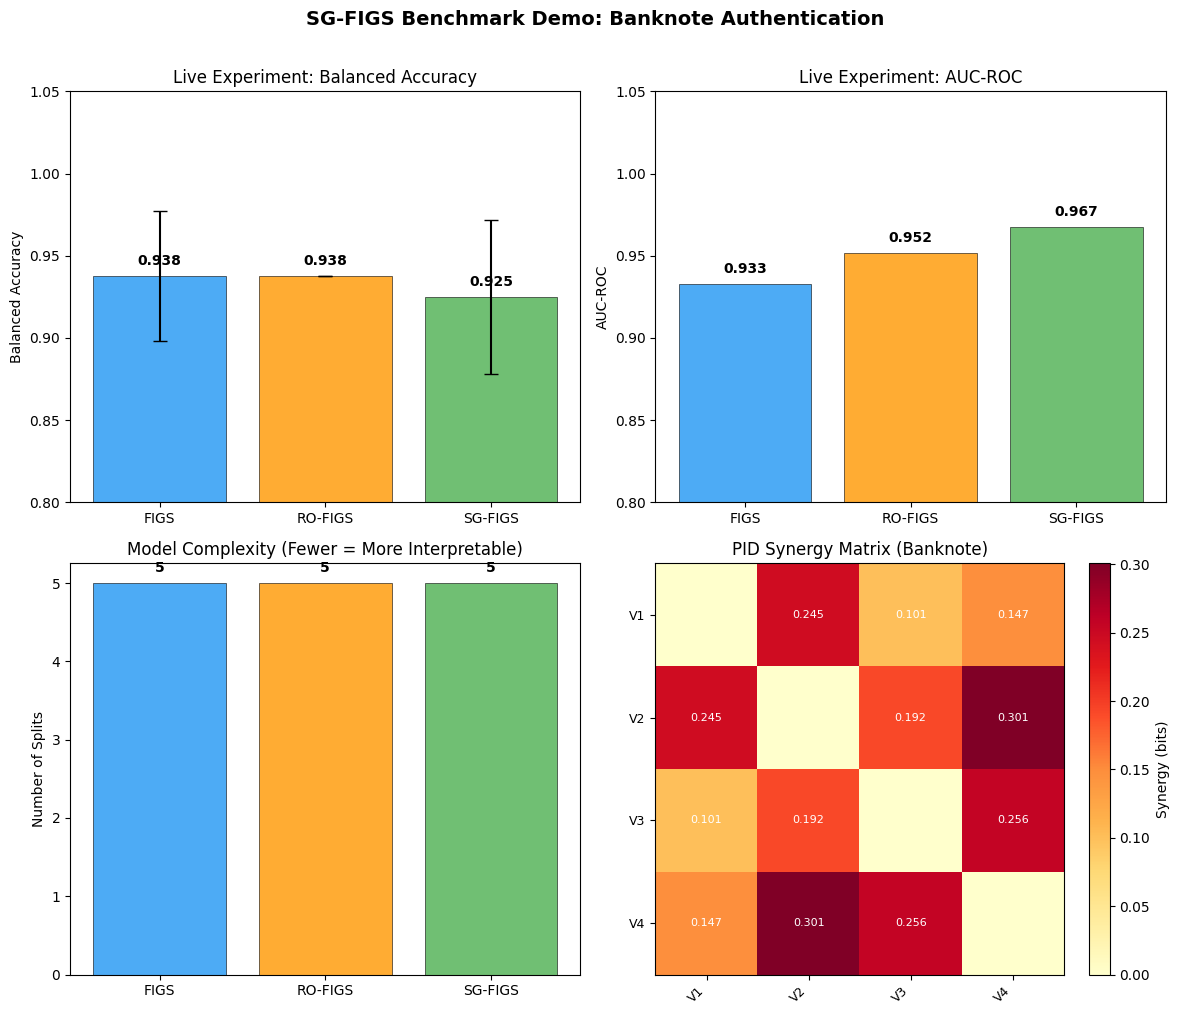


PRE-COMPUTED RESULTS (from full experiment)

Dataset                    FIGS    RO-FIGS    SG-FIGS
----------------------------------------------------
banknote                 0.9793     0.9889     0.9905
pima_diabetes            0.7090     0.7127     0.7069

LIVE EXPERIMENT RESULTS (banknote, this run)
  FIGS      : Acc=0.9375, AUC=0.9328, Splits=5, Time=0.3s
  RO-FIGS   : Acc=0.9375, AUC=0.9516, Splits=5, Time=0.2s
  SG-FIGS   : Acc=0.9250, AUC=0.9672, Splits=5, Time=0.2s


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

methods = list(live_results.keys())
colors = ['#2196F3', '#FF9800', '#4CAF50']

# --- Plot 1: Balanced Accuracy (live) ---
ax = axes[0, 0]
accs = [live_results[m]['mean_accuracy'] for m in methods]
stds = [live_results[m]['std_accuracy'] for m in methods]
bars = ax.bar(methods, accs, yerr=stds, color=colors, alpha=0.8,
              capsize=5, edgecolor='black', linewidth=0.5)
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Live Experiment: Balanced Accuracy')
ax.set_ylim(0.8, 1.05)
for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# --- Plot 2: AUC (live) ---
ax = axes[0, 1]
aucs = [live_results[m].get('mean_auc', 0) or 0 for m in methods]
bars = ax.bar(methods, aucs, color=colors, alpha=0.8,
              edgecolor='black', linewidth=0.5)
ax.set_ylabel('AUC-ROC')
ax.set_title('Live Experiment: AUC-ROC')
ax.set_ylim(0.8, 1.05)
for bar, auc in zip(bars, aucs):
    if auc > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

# --- Plot 3: Model Complexity (splits) ---
ax = axes[1, 0]
splits = [live_results[m]['mean_splits'] for m in methods]
bars = ax.bar(methods, splits, color=colors, alpha=0.8,
              edgecolor='black', linewidth=0.5)
ax.set_ylabel('Number of Splits')
ax.set_title('Model Complexity (Fewer = More Interpretable)')
for bar, s in zip(bars, splits):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{s:.0f}', ha='center', va='bottom', fontweight='bold')

# --- Plot 4: Synergy Matrix Heatmap ---
ax = axes[1, 1]
S = synergy_info['synergy_matrix']
feature_labels = ds['feature_names']
im = ax.imshow(S, cmap='YlOrRd', aspect='auto')
ax.set_xticks(range(len(feature_labels)))
ax.set_yticks(range(len(feature_labels)))
ax.set_xticklabels(feature_labels, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(feature_labels, fontsize=9)
ax.set_title('PID Synergy Matrix (Banknote)')
plt.colorbar(im, ax=ax, label='Synergy (bits)')

# Add synergy values as text
for i in range(len(feature_labels)):
    for j in range(len(feature_labels)):
        if S[i, j] > 0.001:
            ax.text(j, i, f'{S[i,j]:.3f}', ha='center', va='center',
                    fontsize=8, color='black' if S[i,j] < 0.05 else 'white')

plt.suptitle('SG-FIGS Benchmark Demo: Banknote Authentication',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# --- Pre-computed results comparison ---
print("\n" + "=" * 60)
print("PRE-COMPUTED RESULTS (from full experiment)")
print("=" * 60)
print(f"\n{'Dataset':<20} {'FIGS':>10} {'RO-FIGS':>10} {'SG-FIGS':>10}")
print("-" * 52)
for ds_name, methods_dict in precomputed.items():
    figs = methods_dict.get('FIGS', {}).get('mean_accuracy')
    ro = methods_dict.get('RO-FIGS', {}).get('mean_accuracy')
    sg = methods_dict.get('SG-FIGS', {}).get('mean_accuracy')
    f_s = f"{figs:.4f}" if figs else "N/A"
    r_s = f"{ro:.4f}" if ro else "N/A"
    s_s = f"{sg:.4f}" if sg else "N/A"
    print(f"{ds_name:<20} {f_s:>10} {r_s:>10} {s_s:>10}")

print("\n" + "=" * 60)
print("LIVE EXPERIMENT RESULTS (banknote, this run)")
print("=" * 60)
for m in live_results:
    r = live_results[m]
    auc_str = f", AUC={r['mean_auc']:.4f}" if r['mean_auc'] else ""
    print(f"  {m:<10}: Acc={r['mean_accuracy']:.4f}"
          f"{auc_str}, Splits={r['mean_splits']:.0f}"
          f", Time={r['time']:.1f}s")